In [1]:
import optuna
import pandas as pd
import os
import matplotlib.pyplot as plt
from optuna.visualization._parallel_coordinate import _get_parallel_coordinate_info
from optuna.visualization._utils import _check_plot_args
from optuna.visualization._utils import _filter_nonfinite
from optuna.visualization._utils import _get_skipped_trial_numbers
from optuna.visualization._utils import _is_log_scale
from optuna.visualization._utils import _is_numerical
from optuna.visualization._utils import _is_reverse_scale
from optuna.visualization._slice import _SlicePlotInfo

In [2]:
from collections import defaultdict
from collections.abc import Callable
import math
from typing import Any
from typing import cast
from typing import NamedTuple

import numpy as np

from optuna.distributions import CategoricalDistribution
from optuna.logging import get_logger
from optuna.study import Study
from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from optuna.visualization._plotly_imports import _imports
from optuna.visualization._utils import _check_plot_args
from optuna.visualization._utils import _filter_nonfinite
from optuna.visualization._utils import _get_skipped_trial_numbers
from optuna.visualization._utils import _is_log_scale
from optuna.visualization._utils import _is_numerical
from optuna.visualization._utils import _is_reverse_scale

if _imports.is_successful():
    from optuna.visualization._plotly_imports import go
    from optuna.visualization._utils import COLOR_SCALE

_logger = get_logger(__name__)

class _DimensionInfo(NamedTuple):
    label: str
    values: tuple[float, ...]
    range: tuple[float, float]
    is_log: bool
    is_cat: bool
    tickvals: list[int | float]
    ticktext: list[str]


class _ParallelCoordinateInfo(NamedTuple):
    dim_objective: _DimensionInfo
    dims_params: list[_DimensionInfo]
    reverse_scale: bool
    target_name: str

In [3]:
BASE_PATH = "."
FIGURE_PATH = os.path.join(BASE_PATH, "figures")

# Optuna Visualization Functions

Here you find the custom visualization scripts I made.

Mostly taken from Optuna source code and tweaked:

https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/index.html

In [4]:
def _get_parallel_coordinate_info(
    study: Study,
    params: list[str] | None = None,
    target: Callable[[FrozenTrial], float] | None = None,
    target_name: str = "Objective Value",
) -> _ParallelCoordinateInfo:
    _check_plot_args(study, target, target_name)

    reverse_scale = _is_reverse_scale(study, target)

    trials = _filter_nonfinite(
        study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,)), target=target
    )

    # Convert non-hashable parameter values to strings
    for trial in trials:
        trial.params = {k: str(v) if not isinstance(v, (str, int, float, bool, type(None))) else v 
                    for k, v in trial.params.items()}

    all_params = {p_name for t in trials for p_name in t.params.keys()}
    if params is not None:
        for input_p_name in params:
            if input_p_name not in all_params:
                raise ValueError("Parameter {} does not exist in your study.".format(input_p_name))
        all_params = set(params)
    sorted_params = sorted(all_params)

    if target is None:

        def _target(t: FrozenTrial) -> float:
            return cast(float, t.value)

        target = _target

    skipped_trial_numbers = _get_skipped_trial_numbers(trials, sorted_params)

    objectives = tuple([target(t) for t in trials if t.number not in skipped_trial_numbers])
    # The value of (0, 0) is a dummy range. It is ignored when we plot.
    objective_range = (min(objectives), max(objectives)) if len(objectives) > 0 else (0, 0)
    dim_objective = _DimensionInfo(
        label=target_name,
        values=objectives,
        range=objective_range,
        is_log=False,
        is_cat=False,
        tickvals=[],
        ticktext=[],
    )

    if len(trials) == 0:
        _logger.warning("Your study does not have any completed trials.")
        return _ParallelCoordinateInfo(
            dim_objective=dim_objective,
            dims_params=[],
            reverse_scale=reverse_scale,
            target_name=target_name,
        )

    if len(objectives) == 0:
        _logger.warning("Your study has only completed trials with missing parameters.")
        return _ParallelCoordinateInfo(
            dim_objective=dim_objective,
            dims_params=[],
            reverse_scale=reverse_scale,
            target_name=target_name,
        )

    numeric_cat_params_indices: list[int] = []
    dims = []
    for dim_index, p_name in enumerate(sorted_params, start=1):
        values = []
        is_categorical = False
        for t in trials:
            if t.number in skipped_trial_numbers:
                continue
            if p_name in t.params:
                values.append(t.params[p_name])
                is_categorical |= isinstance(t.distributions[p_name], CategoricalDistribution)
        if _is_log_scale(trials, p_name):
            values = [math.log10(v) for v in values]
            min_value = min(values)
            max_value = max(values)
            tickvals: list[int | float] = list(
                range(math.ceil(min_value), math.floor(max_value) + 1)
            )
            if min_value not in tickvals:
                tickvals = [min_value] + tickvals
            if max_value not in tickvals:
                tickvals = tickvals + [max_value]
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min_value, max_value),
                is_log=True,
                is_cat=False,
                tickvals=tickvals,
                ticktext=["{:.3g}".format(math.pow(10, x)) for x in tickvals],
            )
        elif is_categorical:
            vocab: defaultdict[int | str, int] = defaultdict(lambda: len(vocab))

            ticktext: list[str]
            if _is_numerical(trials, p_name):
                _ = [vocab[v] for v in sorted(values)]
                values = [vocab[v] for v in values]
                ticktext = [str(v) for v in list(sorted(vocab.keys()))]
                numeric_cat_params_indices.append(dim_index)
            else:
                values = [vocab[v] for v in values]
                ticktext = [str(v) for v in list(sorted(vocab.keys(), key=lambda x: vocab[x]))]
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min(values), max(values)),
                is_log=False,
                is_cat=True,
                tickvals=list(range(len(vocab))),
                ticktext=ticktext,
            )
        else:
            dim = _DimensionInfo(
                label=_truncate_label(p_name),
                values=tuple(values),
                range=(min(values), max(values)),
                is_log=False,
                is_cat=False,
                tickvals=[],
                ticktext=[],
            )

        dims.append(dim)

    if numeric_cat_params_indices:
        dims.insert(0, dim_objective)
        # np.lexsort consumes the sort keys the order from back to front.
        # So the values of parameters have to be reversed the order.
        idx = np.lexsort([dims[index].values for index in numeric_cat_params_indices][::-1])
        updated_dims = []
        for dim in dims:
            # Since the values are mapped to other categories by the index,
            # the index will be swapped according to the sorted index of numeric params.
            updated_dims.append(
                _DimensionInfo(
                    label=dim.label,
                    values=tuple(np.array(dim.values)[idx]),
                    range=dim.range,
                    is_log=dim.is_log,
                    is_cat=dim.is_cat,
                    tickvals=dim.tickvals,
                    ticktext=dim.ticktext,
                )
            )
        dim_objective = updated_dims[0]
        dims = updated_dims[1:]

    return _ParallelCoordinateInfo(
        dim_objective=dim_objective,
        dims_params=dims,
        reverse_scale=reverse_scale,
        target_name=target_name,
    )

def _truncate_label(label: str) -> str:
    return label if len(label) < 20 else "{}...".format(label[:17])


In [5]:
def parallel_coordinate_plot(study, name):
    from optuna.visualization.matplotlib._matplotlib_imports import Axes
    from optuna.visualization.matplotlib._matplotlib_imports import LineCollection
    from optuna.visualization.matplotlib._matplotlib_imports import plt
    import numpy as np

    import copy

    # Create a deep copy and convert all non-hashable parameters to strings
    study_copy = copy.deepcopy(study)
    for trial in study_copy.trials:
        new_params = {}
        for key, value in trial.params.items():
            try:
                hash(value)  # Test if value is hashable
                new_params[key] = value
            except TypeError:
                new_params[key] = str(value)
        trial.params = new_params

    info = _get_parallel_coordinate_info(study_copy, None, None, "Evaluation Loss")
    
    reversescale = info.reverse_scale
    target_name = info.target_name

    # Set up the graph style.
    fig, ax = plt.subplots(figsize=(20,10))
    plt.subplots_adjust(bottom=0.2)  # Increase bottom margin for x-tick labels
    
    cmap = plt.get_cmap("Blues_r" if reversescale else "Blues")
    ax.set_title(f"Parallel Coordinate Plot - {name}")
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(False)  # Remove horizontal grid lines

    # Prepare data for plotting.
    if len(info.dims_params) == 0 or len(info.dim_objective.values) == 0:
        return ax

    obj_min = info.dim_objective.range[0]
    obj_max = info.dim_objective.range[1]
    obj_w = obj_max - obj_min
    dims_obj_base = [[o] for o in info.dim_objective.values]
    for dim in info.dims_params:
        p_min = dim.range[0]
        p_max = dim.range[1]
        p_w = p_max - p_min

        if p_w == 0.0:
            center = obj_w / 2 + obj_min
            for i in range(len(dim.values)):
                dims_obj_base[i].append(center)
        else:
            for i, v in enumerate(dim.values):
                dims_obj_base[i].append((v - p_min) / p_w * obj_w + obj_min)

    # Draw multiple line plots and axes.
    # Ref: https://stackoverflow.com/a/50029441
    n_params = len(info.dims_params)
    ax.set_xlim(0, n_params)
    ax.set_ylim(info.dim_objective.range[0], info.dim_objective.range[1])
    xs = [range(n_params + 1) for _ in range(len(dims_obj_base))]
    segments = [np.column_stack([x, y]) for x, y in zip(xs, dims_obj_base)]
    lc = LineCollection(segments, cmap=cmap)
    lc.set_array(np.asarray(info.dim_objective.values))
    axcb = fig.colorbar(lc, pad=0.1, ax=ax)
    axcb.set_label(target_name)
    var_names = [info.dim_objective.label] + [dim.label for dim in info.dims_params]
    plt.xticks(range(n_params + 1), var_names, rotation=15, ha='right')

    for i, dim in enumerate(info.dims_params):
        ax2 = ax.twinx()
        if dim.is_log:
            ax2.set_ylim(np.power(10, dim.range[0]), np.power(10, dim.range[1]))
            ax2.set_yscale("log")
        else:
            ax2.set_ylim(dim.range[0], dim.range[1])
        ax2.spines["top"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
        ax2.spines["right"].set_visible(True)  # Make parameter axes visible
        ax2.spines["right"].set_color('black')
        ax2.xaxis.set_visible(False)
        ax2.grid(False)  # Remove grid lines from parameter axes
        ax2.spines["right"].set_position(("axes", (i + 1) / n_params))
        if dim.is_cat:
            ax2.set_yticks(dim.tickvals)
            ax2.set_yticklabels(dim.ticktext)

    ax.add_collection(lc)

    return fig

In [6]:
def get_importances_plot(study, name):
    from optuna.visualization._param_importances import _get_importances_infos
    import numpy as np

    AXES_PADDING_RATIO = 1.05
    
    def _set_bar_labels(info, fig, ax, offset) -> None:
        # Figure canvas does not necessarily have a get_renderer.
        assert hasattr(fig.canvas, "get_renderer")
        renderer = fig.canvas.get_renderer()
        for idx, (val, label) in enumerate(zip(info.importance_values, info.importance_labels)):
            text = ax.text(val, idx + offset, label, va="center")

            # Sometimes horizontal axis needs to be re-scaled
            # to avoid text going over plot area.
            bbox = text.get_window_extent(renderer)
            bbox = bbox.transformed(ax.transData.inverted())
            _, plot_xmax = ax.get_xlim()
            bbox_xmax = bbox.xmax

            if bbox_xmax > plot_xmax:
                ax.set_xlim(xmax=AXES_PADDING_RATIO * bbox_xmax)

    infos = _get_importances_infos(study, None, None, None, "Evaluation Loss")
    # Set up the graph style.
    plt.style.use("ggplot")  # Use ggplot style sheet for similar outputs to plotly.
    fig, ax = plt.subplots()
    ax.set_title(f"Hyperparameter Importances - {name}", loc="left", pad=10)
    ax.set_xlabel("Hyperparameter Importance")
    ax.set_ylabel("Hyperparameter")
    height = 0.8 / len(infos)  # Default height split between objectives.

    for objective_id, info in enumerate(infos):
        param_names = info.param_names
        pos = np.arange(len(param_names))
        offset = height * objective_id
        importance_values = info.importance_values

        if not importance_values:
            continue

        # Draw horizontal bars.
        ax.barh(
            pos + offset,
            importance_values,
            height=height,
            align="center",
            label=info.target_name,
            color=plt.get_cmap("tab20c")(objective_id),
        )

        _set_bar_labels(info, fig, ax, offset)
        ax.set_yticks(pos + offset / 2, param_names)

    ax.legend(loc="best")

    # Add these lines before return fig:
    fig.tight_layout()
    
    # Ensure y-axis labels are fully visible
    ax.margins(y=0.02)  # Small margin for y-axis
    return fig

In [7]:
def get_slice_plot(study, name):
    import matplotlib

    info = _get_slice_plot_info(study, None, None, "Evaluation Loss")

    if len(info.subplots) == 0:
        _, ax = plt.subplots()
        return ax

    # Set up the graph style.
    cmap = plt.get_cmap("Blues")
    padding_ratio = 0.05
    plt.style.use("ggplot")  # Use ggplot style sheet for similar outputs to plotly.

    if len(info.subplots) == 1:
        # Set up the graph style.
        fig, axs = plt.subplots()
        axs.set_title("Slice Plot")

        # Draw a scatter plot.
        sc = _generate_slice_subplot(info.subplots[0], axs, cmap, padding_ratio, info.target_name)
    else:
        # Set up the graph style.
        min_figwidth = matplotlib.rcParams["figure.figsize"][0] / 2
        fighight = matplotlib.rcParams["figure.figsize"][1]
        # Ensure that each subplot has a minimum width without relying on auto-sizing.
        fig, axs = plt.subplots(
            1,
            len(info.subplots),
            sharey=True,
            figsize=(min_figwidth * len(info.subplots), fighight),
        )
        fig.suptitle(f"Slice Plot - {name}")

        # Draw scatter plots.
        for i, subplot in enumerate(info.subplots):
            ax = axs[i]
            sc = _generate_slice_subplot(subplot, ax, cmap, padding_ratio, info.target_name)

    axcb = fig.colorbar(sc, ax=axs)
    axcb.set_label("Trial")

    return fig

def _generate_slice_subplot(
    subplot_info,
    ax,
    cmap,
    padding_ratio,
    target_name,
):
    from optuna.visualization._slice import _PlotValues
    ax.set(xlabel=subplot_info.param_name, ylabel=target_name)
    scale = None

    feasible = _PlotValues([], [], [])
    infeasible = _PlotValues([], [], [])
    for x, y, num, c in zip(
        subplot_info.x, subplot_info.y, subplot_info.trial_numbers, subplot_info.constraints
    ):
        if x is not None or x != "None" or y is not None or y != "None":
            if c:
                feasible.x.append(x)
                feasible.y.append(y)
                feasible.trial_numbers.append(num)
            else:
                infeasible.x.append(x)
                infeasible.y.append(y)
                infeasible.trial_numbers.append(num)
    if subplot_info.is_log:
        ax.set_xscale("log")
        scale = "log"
    if subplot_info.is_numerical:
        feasible_x = feasible.x
        feasible_y = feasible.y
        feasible_c = feasible.trial_numbers
        infeasible_x = infeasible.x
        infeasible_y = infeasible.y
    else:
        feasible_x, feasible_y, feasible_c = _get_categorical_plot_values(subplot_info, feasible)
        infeasible_x, infeasible_y, _ = _get_categorical_plot_values(subplot_info, infeasible)
        scale = "categorical"
    xlim = _calc_lim_with_padding(feasible_x + infeasible_x, padding_ratio, scale)
    ax.set_xlim(xlim[0], xlim[1])
    sc = ax.scatter(feasible_x, feasible_y, c=feasible_c, cmap=cmap, edgecolors="grey")
    ax.scatter(infeasible_x, infeasible_y, c="#cccccc", label="Infeasible Trial")
    ax.label_outer()

    return sc


def _get_categorical_plot_values(
    subplot_info, values
) -> tuple[list[Any], list[float], list[int]]:
    assert subplot_info.x_labels is not None
    value_x = []
    value_y = []
    value_c = []
    points_dict = defaultdict(list)
    for x, y, number in zip(values.x, values.y, values.trial_numbers):
        points_dict[x].append((y, number))
    for x_label in subplot_info.x_labels:
        for y, number in points_dict[x_label]:
            value_x.append(str(x_label))
            value_y.append(y)
            value_c.append(number)
    return value_x, value_y, value_c


def _calc_lim_with_padding(
    values: list[Any], padding_ratio: float, scale: str | None
) -> tuple[float, float]:
    value_max = max(values)
    value_min = min(values)
    if scale == "log":
        padding = (math.log10(value_max) - math.log10(value_min)) * padding_ratio
        return (
            math.pow(10, math.log10(value_min) - padding),
            math.pow(10, math.log10(value_max) + padding),
        )
    elif scale == "categorical":
        width = len(set(values)) - 1
        padding = width * padding_ratio
        return -padding, width + padding
    else:
        padding = (value_max - value_min) * padding_ratio
        return value_min - padding, value_max + padding

def _get_slice_plot_info(
    study: Study,
    params: list[str] | None,
    target: Callable[[FrozenTrial], float] | None,
    target_name: str,
) -> _SlicePlotInfo:
    
    from optuna.visualization._slice import _get_slice_subplot_info

    _check_plot_args(study, target, target_name)

    trials = _filter_nonfinite(
        study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,)), target=target
    )

    if len(trials) == 0:
        _logger.warning("Your study does not have any completed trials.")
        return _SlicePlotInfo(target_name, [])

    # Convert non-hashable parameter values to strings BEFORE any processing
    for trial in trials:
        # Convert both params and any other parameter references
        converted_params = {}
        for k, v in trial.params.items():
            if not isinstance(v, (str, int, float, bool, type(None))):
                converted_params[k] = str(v)
            else:
                converted_params[k] = v
        trial.params = converted_params

    all_params = {p_name for t in trials for p_name in t.params.keys()}

    distributions = {}
    for trial in trials:
        for param_name, distribution in trial.distributions.items():
            if param_name not in distributions:
                distributions[param_name] = distribution

    x_labels = {}
    for param_name, distribution in distributions.items():
        if isinstance(distribution, CategoricalDistribution):
            # Also convert distribution choices to strings if they're non-hashable
            choices = []
            for choice in distribution.choices:
                if not isinstance(choice, (str, int, float, bool, type(None))):
                    choices.append(str(choice))
                else:
                    choices.append(choice)
            x_labels[param_name] = choices

    if params is None:
        sorted_params = sorted(all_params)
    else:
        for input_p_name in params:
            if input_p_name not in all_params:
                raise ValueError(f"Parameter {input_p_name} does not exist in your study.")
        sorted_params = sorted(set(params))

    return _SlicePlotInfo(
        target_name=target_name,
        subplots=[
            _get_slice_subplot_info(
                trials=trials,
                param=param,
                target=target,
                log_scale=_is_log_scale(trials, param),
                numerical=not isinstance(distributions[param], CategoricalDistribution),
                x_labels=x_labels.get(param),
            )
            for param in sorted_params
        ],
    )

In [8]:
import pandas as pd
from tqdm import tqdm
import wandb
import pickle, os
from datetime import datetime

def load_study(name, runs_path="./runs"):
    import optuna

    storage = f'sqlite:///{os.path.join(runs_path,name,"optuna.db")}'

    study = optuna.load_study(
        study_name="wav2vec2_tuning_loss",
        storage=storage
    )

    return study

def load_runs(study, runs_path="./runs", sampled=False, force=False):
    import wandb
    import pickle
    import os
    from tqdm import tqdm

    cache_path = os.path.join(runs_path, study)
    # Check if cached version exists
    if not force and (cache_path and os.path.exists(os.path.join(cache_path, 'runs.pkl'))):
        print(f"Loading cached runs from {cache_path}/runs.pkl")
        with open(os.path.join(cache_path, 'runs.pkl'), 'rb') as f:
            return pickle.load(f)

    print(f"Fetching wandb project: {study}")
    api = wandb.Api()
    runs = api.runs(f"{api.default_entity}/{study}")

    runs_dict = {}
    for run in tqdm(runs, total=len(runs), desc="Loading runs"):
        if sampled:
            df = run.history()
        else:
            df = pd.DataFrame([h for h in run.scan_history()])
        # Fix key spelling errors...
        new_map = {
            "val_contrastive_loss" : "val_contrast_loss",
            "constrast_loss" : "contrast_loss",
            "div_loss" : "diversity_loss"
        }
        df = df.rename(columns=new_map)

        runs_dict[run.name] = df

    # Cache the result if cache_path is provided
    if cache_path:
        os.makedirs(cache_path, exist_ok=True)
        cache_file = os.path.join(cache_path, 'runs.pkl')
        print(f"Caching runs to {cache_file}")
        with open(cache_file, 'wb') as f:
            pickle.dump(runs_dict, f)
    
    return runs_dict

def load_data(study, runs_path="./runs", force=False, sampled=False):
    df = load_study(study, runs_path=runs_path).trials_dataframe()
    df['datetime_start'] = pd.to_datetime(df['datetime_start'])
    
    runs = load_runs(study, runs_path=runs_path, force=force, sampled=sampled)
    
    # Runs may be shorter than df, so we need to match according to timestamp
    def adjust_runs(runs, df):
        print("Mapping wandb runs to optuna trials...")
        run_list = [None]*len(df)
        for timestamp, run in tqdm(runs.items()):
            try:
                wandb_time = datetime.strptime(timestamp, "%Y%m%d-%H%M%S")
            except ValueError:
                print(f"Warning: Could not parse wandb run name '{timestamp}' with expected format. Skipping.")
                continue
            
            # Find all df entries with timestamps earlier than wandb_time
            earlier_entries = df[df['datetime_start'] < wandb_time]
            
            if not earlier_entries.empty:
                # Get the latest (maximum) timestamp that's still earlier
                latest_earlier_idx = earlier_entries['datetime_start'].idxmax()
                # Add the wandb data to that row
                run_list[latest_earlier_idx] = run

            else:
                print(f"Skipping - no ealier entries")
        
        return run_list
    
    run_list = adjust_runs(runs, df)
    df["run"] = run_list
    return df

# Optuna Visuals

Generates all visuals

In [9]:
def visualize_studies(study_names: list):
    studies = {}
    for name in study_names:
        studies[name] = load_study(name)
    
    for exp in studies.keys():
        study = studies[exp]
        if study is None:
            print(f"Study {exp} not found.")
            continue
        
        name = " ".join(exp.split("-")[:-1]).title()

        print(f"Optuna Visuals for {name}")

        fig = parallel_coordinate_plot(study, name)
        fig.savefig(os.path.join(FIGURE_PATH, f"parallel_coordinate_{exp}.png"), bbox_inches='tight', dpi=150, pad_inches=0.1)

        fig = get_importances_plot(study, name)
        fig.savefig(os.path.join(FIGURE_PATH, f"importances_{exp}.png"), bbox_inches='tight', dpi=150, pad_inches=0.1)

        fig = get_slice_plot(study, name)
        fig.savefig(os.path.join(FIGURE_PATH, f"slice_plot_{exp}.png"), bbox_inches='tight', dpi=150, pad_inches=0.1)

        print(study.best_params)

## Calibration Studies

In [10]:
# calibration_studies = [
#     "optuna-initialized-rvi_mdb", 
#     "optuna-uninitialized-rvi_mdb",
#     "pretrain-optuna-pre_rvi_mdb"
#     ]

# visualize_studies(calibration_studies)

## Pretrain Refinement

This optuna study is for the final refinement of the pretraining hyperparams

In [11]:
final_studies = [
    "pretrain-optuna-refine-pre_rvi_mdb"
    ]

visualize_studies(final_studies)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [12]:
st = load_study(final_studies[0])
dat = load_data(final_studies[0])


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

Let us explore the best parameters:

In [13]:
# Best Parameters - strange, shouldn't be able to represent more than 4 tokens
refine_a = dat.loc[dat["value"].dropna().nsmallest(5).index]


NameError: name 'dat' is not defined

In [14]:
refine_a

NameError: name 'refine_a' is not defined

We use a modified variant of 134 and 126, where each has 2*8 code vectors - as having < 5 makes it impossible to learn the desired representation.
A variant of 134 with stride [4,2,1] will also be used as an ablation - see variant c.
Turns out the optuna run had [4,2,2], and not the above. Add as a d-run.

Once all pretrainings done - do a superficial fine-tuning on each, do judge viability.
For viable models, initialize them, and run optuna on the initialized models.
Use most promising for final training.


## Finetune Refinement

In [15]:
final_studies = [f"optuna-refined-{c}-rvi_mdb" for c in ["a", "b", "c", "d"]]

visualize_studies(final_studies)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

# WANDB Visuals

This section extracts visuals from WANDB

In [16]:
import matplotlib.pyplot as plt

def plot_loss_ax(ax, run_data, metric, train_prefix="", val_prefix="", 
                 color='blue', title='Training Loss', val=True, label="", **kwargs):
    """
    Plot training and validation loss on the given axis
    
    Parameters:
    ax: matplotlib axis object
    run_data: DataFrame with 'loss' and 'val_loss' columns
    color: color for both lines
    title: plot title
    """
    try:
        # Plot loss with solid line
        y_data = run_data[f'{train_prefix}{metric}'].interpolate()
        ax.plot(run_data["_step"], y_data, 
                label=f'{label}Training' if kwargs.get("include_label", True) else "", 
                alpha = kwargs.get("line_alpha", 1)/3 if kwargs.get("trend_window", None) else kwargs.get("line_alpha", 1),
                color=color, 
                linestyle='-')
        
        if kwargs.get("trend_window", None):
            smoothed = y_data.rolling(window=kwargs.get("trend_window", None)).mean()
            ax.plot(run_data["_step"], smoothed, 
                    label=f'{label}Training Trend', 
                    alpha = kwargs.get("line_alpha", 1),
                    color=color, 
                    linestyle='-', 
                    linewidth=2)
        
    except Exception as e:
        print(f"Did not plot {train_prefix}{metric}, due to: \n {e}")

    try:
        if val:
            # Plot validation loss with dashed line, same color
            y_data = run_data[f'{val_prefix}{metric}'].interpolate()
            ax.plot(run_data["_step"], y_data, 
                    label=f'{label}Validation' if kwargs.get("include_label", True) else "", 
                    alpha = kwargs.get("line_alpha", 1)/3 if kwargs.get("val_trend", None) else kwargs.get("line_alpha", 1), 
                    color=color, 
                    linestyle='--')
            
            if kwargs.get("trend_window", None) and kwargs.get("val_trend", False):
                smoothed = y_data.rolling(window=kwargs.get("trend_window", None)).mean()
                ax.plot(run_data["_step"], smoothed, 
                        label=f'{label}Validation Trend', 
                        alpha = kwargs.get("line_alpha", 1),
                        color=color, 
                        linestyle='--', 
                        linewidth=2)
    except Exception as e:
         print(f"Did not plot {val_prefix}{metric}, due to: \n {e}")

    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.5)


## Selection of Refined Pretrainings

This section we highlight the chosen runs to "seed" the refined pretrainings.
As mentioned previously, 2 runs were chosen, where two modifications of the best_params run were also added for more architectural variety / ablation.

In [17]:
PRETRAIN_LOSS_TYPES = ["loss", "contrast_loss", "diversity_loss"]
optuna_pretrain = load_data("pretrain-optuna-refine-pre_rvi_mdb")
selected_runs = [134, 126]
filtered_df = optuna_pretrain[optuna_pretrain["value"] < 0.037]

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

NameError: name 'filtered_df' is not defined

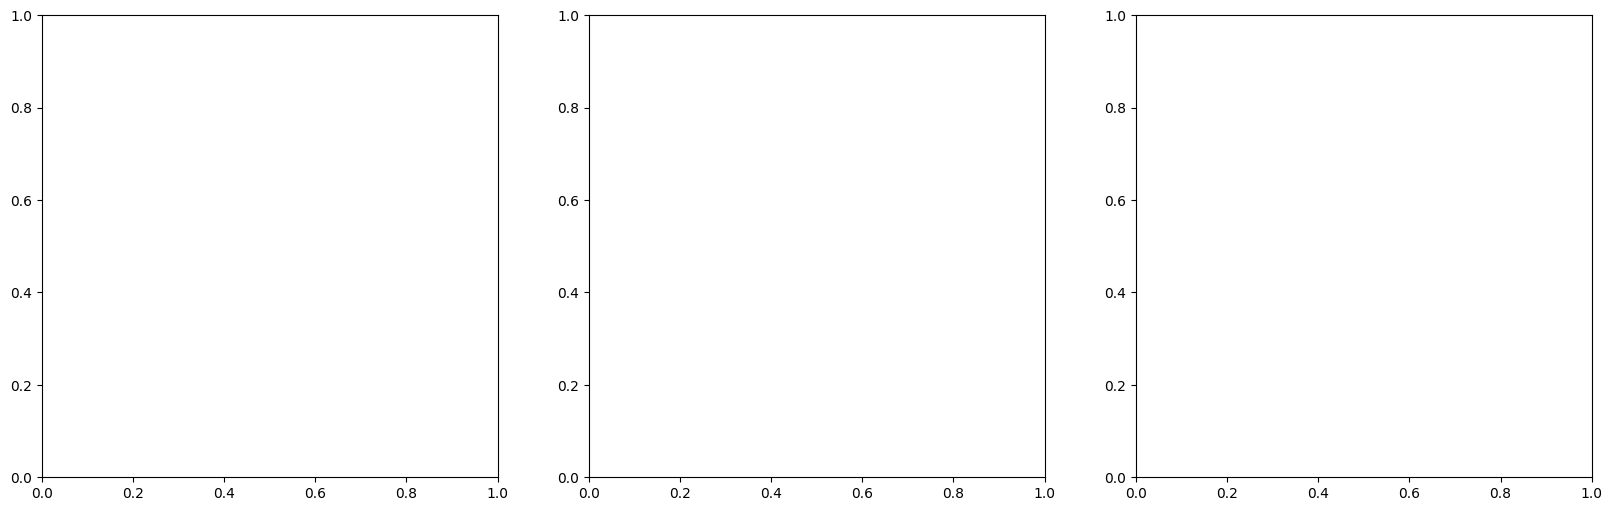

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, entry in filtered_df.iterrows():
    run = entry["run"]
    color = "blue"
    label = None
    line_alpha = 0.1
    include_label=False
    if i in selected_runs:
        color = "red" if i == 126 else "green"
        label = "b - " if i == 126 else "a - "
        line_alpha = 0.7
        include_label=True

    for j, metric in enumerate(PRETRAIN_LOSS_TYPES):
        plot_loss_ax(ax[j], run, metric=metric, color=color, title=" ".join(metric.split("_")).capitalize(), 
                     label=label, val_prefix="val_", line_alpha=line_alpha, include_label=include_label)

ax[0].set_ylim(-0.02, 0.5)
ax[1].set_ylim(-0.02, 0.5)

title = "Pretraining Loss Metrics - Optuna"

fig.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH,title.replace(" ","_") + ".png"))
plt.show()

Did not find the cause of the spikes, but presumably due to length grouping?

## Pretrain Refined

Metrics for the refined pretrainings to view different architectural performances.

In [19]:
import wandb
from matplotlib import pyplot as plt

PRETRAIN_REFINED = [f"pretrain-refined-{c}-pre_rvi_mdb" for c in ["a", "b", "c", "d"]]
PRETRAIN_LOSS_TYPES = ["loss", "contrast_loss", "diversity_loss"]
datdict = {study:list(load_runs(study, force=False).values())[0] for study in PRETRAIN_REFINED}

Fetching wandb project: pretrain-refined-a-pre_rvi_mdb


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 3

/tmp/ipykernel_1981/3178807835.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))


NameError: name 'datdict' is not defined

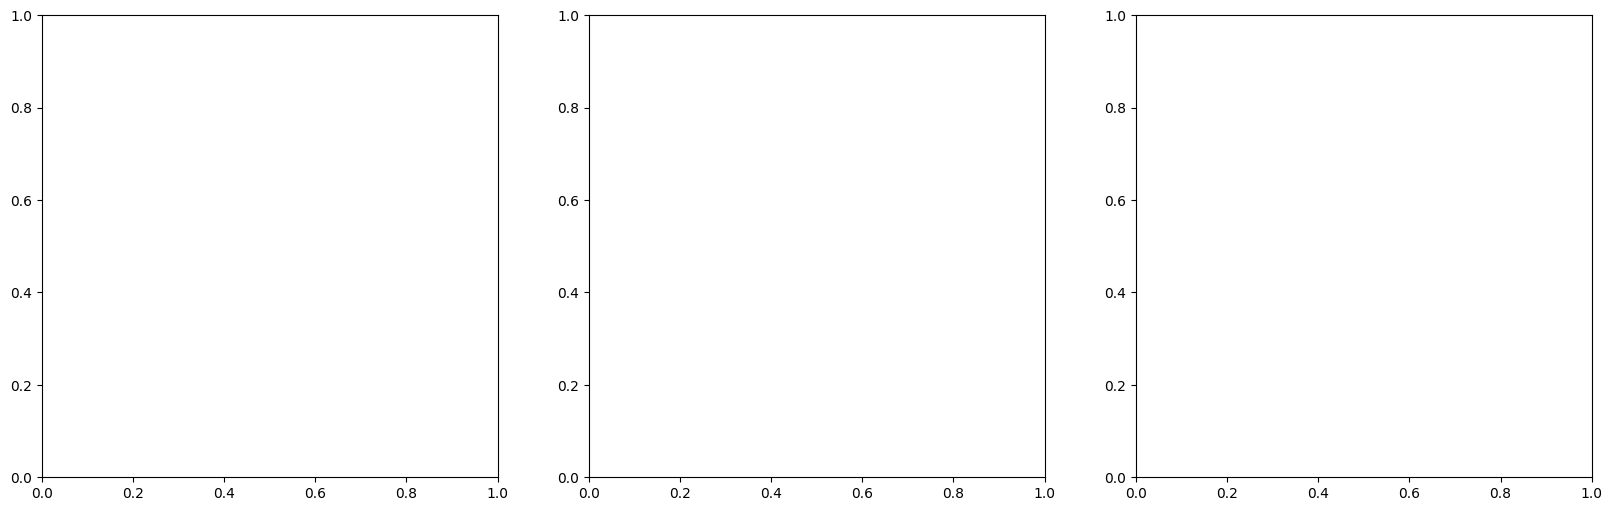

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))

for i, (timestamp, run) in enumerate(datdict.items()):
    color = cols[i]
    label = PRETRAIN_REFINED[i].split("-")[2] + " - "
    for j, metric in enumerate(PRETRAIN_LOSS_TYPES):
        plot_loss_ax(ax[j], run, metric=metric, color=color, title=" ".join(metric.split("_")).capitalize(), 
                     label=label, val_prefix="val_", line_alpha=0.7, trend_window=200)

ax[0].set_ylim(-0.15, 3)
ax[1].set_ylim(-0.15, 3)
ax[2].set_ylim(-0.015, 0.3)

title = "Pretraining Loss Metrics - Refined"

fig.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH,title.replace(" ","_") + ".png"))
plt.show()

It is clear that "a" outperforms the others in the pretraining loss. Let us see how it looks in finetuning.

## Finetuning Initialization on refined pretrainings

In [21]:
FINETUNE_REFINED = [f"finetune-refined-{c}-rvi_mdb" for c in ["a", "b", "c", "d"]]
FINETUNE_LOSS_TYPES = ["wer", "loss"]
datdict = {study:list(load_runs(study).values())[0] for study in FINETUNE_REFINED}

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

Fetching wandb project: finetune-refined-a-rvi_mdb


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 2

/tmp/ipykernel_1981/1311165595.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))


NameError: name 'datdict' is not defined

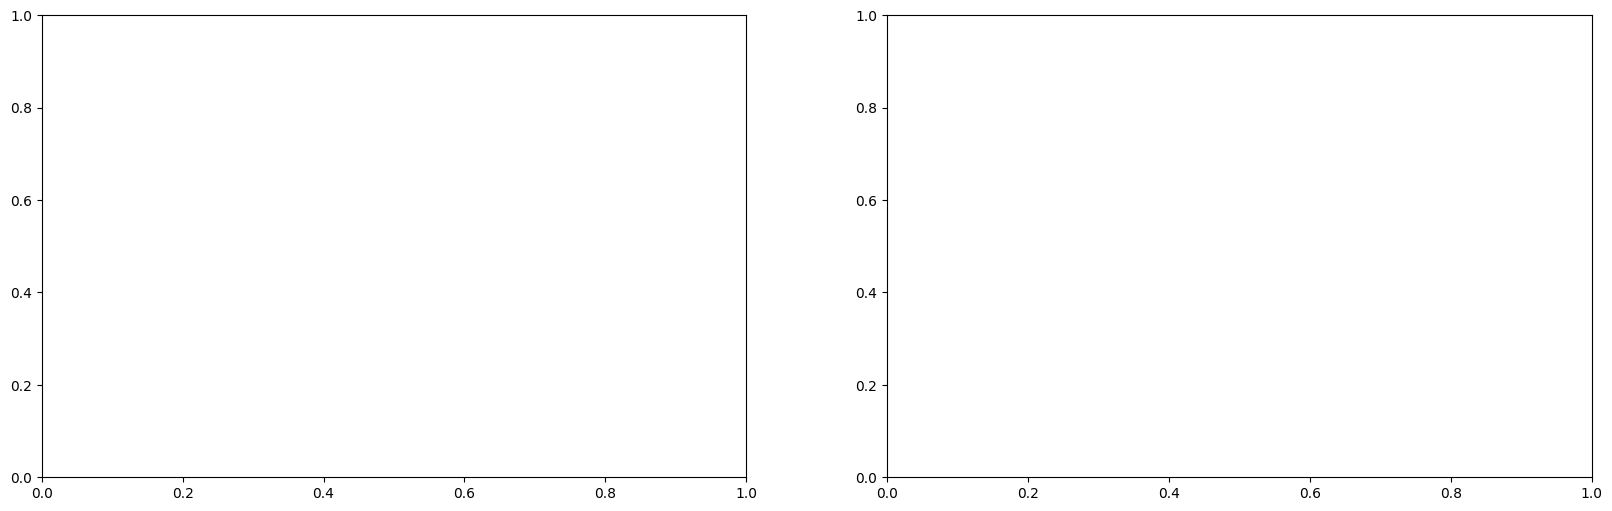

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))

for i, (timestamp, run) in enumerate(datdict.items()):
    color = cols[i]
    label = FINETUNE_REFINED[i].split("-")[2] + " - "
    for j, metric in enumerate(FINETUNE_LOSS_TYPES):
        plot_loss_ax(ax[j], run, metric=metric, train_prefix="train/", val_prefix="eval/", 
                     color=color, title=" ".join(metric.split("_")).capitalize(), label=label)

ax[0].set_ylim(0.3, 1.1)
ax[1].set_ylim(0.5, 5)

title = "Finetuning Metrics - Refined"

fig.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH,title.replace(" ","_") + ".png"))
plt.show()

b looks to be the best, but it is hard to say.
Surprisingly, d does better than a and c.
I may just use these runs as initialization for each of their own optuna run, and then select ideal parameters from there.

Then expand data set, do full run.

## Pretrain Full

In [23]:
import wandb
from matplotlib import pyplot as plt

PRETRAIN_REFINED = [f"pretrain-full-{c}-full_pre_rvi_mdb" for c in ["a", "b", "c", "d"]]
PRETRAIN_LOSS_TYPES = ["loss", "contrast_loss", "diversity_loss"]
datdict = {study:list(load_runs(study, force=False).values())[0] for study in PRETRAIN_REFINED}

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

Fetching wandb project: pretrain-full-a-full_pre_rvi_mdb


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 3

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for i, (timestamp, run) in enumerate(datdict.items()):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))

    color = cols[i]
    label = ""
    for j, metric in enumerate(PRETRAIN_LOSS_TYPES):
        plot_loss_ax(ax[j], run, metric=metric, color=color, title=" ".join(metric.split("_")).capitalize(), 
                     label=label, val_prefix="val_", line_alpha=0.7, trend_window=200)
    
    ax[0].set_ylim(-0.2, 3)
    ax[1].set_ylim(-0.2, 3)

    title = f'Full Pretraining Metrics - {PRETRAIN_REFINED[i].split("-")[2].title()}'

    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_PATH,title.replace(" ","_") + ".png"))
    plt.show()

NameError: name 'datdict' is not defined

## Full Finetunings

In [25]:
FINETUNE_REFINED = [f"finetune-full-{c}-full_rvi_mdb" for c in ["a", "b", "c", "d"]]
FINETUNE_LOSS_TYPES = ["wer", "loss"]
datdict = {study:list(load_runs(study).values())[0] for study in FINETUNE_REFINED}

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

cols = cm.get_cmap('tab10')(np.linspace(0, 1, len(datdict)))

for i, (timestamp, run) in enumerate(datdict.items()):
    color = cols[i]
    label = FINETUNE_REFINED[i].split("-")[2] + " - "
    for j, metric in enumerate(FINETUNE_LOSS_TYPES):
        plot_loss_ax(ax[j], run, metric=metric, train_prefix="train/", val_prefix="eval/", 
                     color=color, title=" ".join(metric.split("_")).capitalize(), label=label,
                     line_alpha=0.6, trend_window=50, val_trend=True)

ax[0].set_ylim(0.2, 0.6)
ax[1].set_ylim(0, 2)

title = f'Full Finetuning Metrics'

fig.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH,title.replace(" ","_") + ".png"))
plt.show()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

Fetching wandb project: finetune-full-a-full_rvi_mdb


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 3